In [1]:
import numpy as np
import matplotlib.pyplot as plt
from joblib import Parallel, delayed
from tqdm import tqdm
from scipy.integrate import quad
import pandas as pd
import random
from pyvbmc import VBMC
from V_A_step_jump_fit_utils import rho_A_t_fn, cum_A_t_fn

# params

In [2]:
N_sim = int(10e3)

dt = 1e-4
dB = np.sqrt(dt)


V_A_old = 2
V_A_new = 2.3
theta_A = 2

rate_lambda = 0.14
T_0 = 0.66 * (1e-3)
theta_E = 40.5

t_A_aff = 0.05
t_E_aff = 0
t_motor = 0

Z_E = 0
L = 0.5

N_print = int(100e5)

T_trunc = 0.3

# get LED times

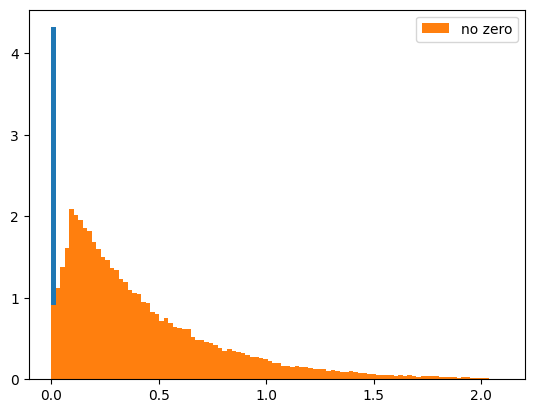

In [3]:
og_df = pd.read_csv('../out_LED.csv')
df = og_df[ og_df['repeat_trial'].isin([0,2]) | og_df['repeat_trial'].isna() ]
session_type = 7    
df = df[ df['session_type'].isin([session_type]) ]
training_level = 16
df = df[ df['training_level'].isin([training_level]) ]

# t_stim_and_led_tuple = [(row['intended_fix'], row['LED_onset_time']) for _, row in df.iterrows()]

LED_times = (df['intended_fix'] - df['LED_onset_time']).values
plt.hist(LED_times, bins=100, density=True);

# remove zero from LED_times
LED_times = LED_times[LED_times != 0]
plt.hist(LED_times, bins=100, density=True, label='no zero');

LED_times = np.unique(LED_times)


stim_times = df['intended_fix'].values
stim_times = np.unique(stim_times)

plt.legend();

# Remove zero LED_onset_times
# filtered_df = df[df['intended_fix'] - df['LED_onset_time'] != 0]

# keep zero LED_onset_times
df = df[ df['LED_trial'] == 1]
tuple_column = list(zip(df['intended_fix'], df['intended_fix'] - df['LED_onset_time']))


# simulator

In [4]:
def psiam_tied_data_gen_wrapper(base_V_A, new_V_A, theta_A, ABL_arr, ILD_arr, rate_lambda, T_0, theta_E, Z_E, t_A_aff, t_E_aff, t_motor, L, \
                                iter_num, N_print, dt):
    ABL = random.choice(ABL_arr)
    ILD = random.choice(ILD_arr)
    
    # t_stim and t_led
    # t_stim = np.random.choice(stim_times)
    # t_led =  np.random.choice(LED_times)

    stim_led_pair = tuple_column[np.random.choice(len(tuple_column))]
    t_stim = stim_led_pair[0]
    t_led = stim_led_pair[1]

    # print after every N_print iterations
    if iter_num % N_print == 0:
        print(f'In iter_num: {iter_num}, ABL: {ABL}, ILD: {ILD}, t_stim: {t_stim}')


    choice, rt, is_act = simulate_psiam_tied(base_V_A, new_V_A, theta_A, ABL, ILD, rate_lambda, T_0, theta_E, Z_E, t_stim, t_led, t_A_aff, t_E_aff, t_motor, L, dt)
    return {'choice': choice, 'rt': rt, 'is_act': is_act ,'ABL': ABL, 'ILD': ILD, 't_stim': t_stim, 't_led': t_led}

def simulate_psiam_tied(base_V_A, new_V_A, theta_A, ABL, ILD, rate_lambda, T_0, theta_E, Z_E, t_stim, t_led, t_A_aff, t_E_aff, t_motor, L, dt):
    AI = 0; DV = Z_E; t = 0; dB = dt**0.5
    
    chi = 17.37; q_e = 1
    theta = theta_E * q_e
    mu = (2*q_e/T_0) * (10**(rate_lambda * ABL/20)) * np.sinh(rate_lambda * ILD/chi)
    sigma = np.sqrt( (2*(q_e**2)/T_0) * (10**(rate_lambda * ABL/20)) * np.cosh(rate_lambda * ILD/ chi) )
    
    is_act = 0
    while True:
        if t*dt < t_led:
            V_A = base_V_A
        else:
            V_A = new_V_A

        if t*dt > t_stim + t_E_aff:
            DV += mu*dt + sigma*np.random.normal(0, dB)
        
        if t*dt > t_A_aff:
            AI += V_A*dt + np.random.normal(0, dB)
        
        t += 1
        
        if DV >= theta:
            choice = +1; RT = t*dt + t_motor
            break
        elif DV <= -theta:
            choice = -1; RT = t*dt + t_motor
            break
        
        if AI >= theta_A:
            is_act = 1
            AI_hit_time = t*dt
            # if t*dt > t_stim - t_motor:
            while t*dt <= (AI_hit_time + t_E_aff + t_motor):#  u can process evidence till stim plays
                if t*dt > t_stim + t_E_aff: # Evid accum wil begin only after stim starts and afferent delay
                    DV += mu*dt + sigma*np.random.normal(0, dB)
                    if DV >= theta:
                        DV = theta
                        break
                    elif DV <= -theta:
                        DV = -theta
                        break
                t += 1
            
            break
        
        
    if is_act == 1:
        RT = AI_hit_time + t_motor
        # if DV != 0:
        if DV >= (1 + (L/2) - 1)*theta:
            choice = 1
        elif DV <= (1 - (L/2) - 1)*theta:
            choice = -1
        else:
            prob_hit_up = (1/L)*((DV/theta) + 1) + (0.5 - (1/L))            
            if np.random.rand() <= prob_hit_up:
                choice = 1
            else:
                choice = -1
    
    return choice, RT, is_act

In [5]:
sim_results = Parallel(n_jobs=-1)(delayed(psiam_tied_data_gen_wrapper)(V_A_old, V_A_new, theta_A, np.unique(df['ABL'].values), np.unique(df['ILD'].values), \
                                                                       rate_lambda, T_0, theta_E, Z_E, t_A_aff, t_E_aff, t_motor, L, \
                                iter_num, N_print, dt) for iter_num in range(N_sim))

In iter_num: 0, ABL: 60, ILD: 1.0, t_stim: 0.635363963735096


In [6]:
num_aborts = len([ 1 for res in sim_results if res['rt'] < res['t_stim'] ]) 
print(f'% of aborts = {100*num_aborts/N_sim}')

% of aborts = 20.01


In [7]:
# num of aborts > T_trunc
num_aborts = len([ 1 for res in sim_results if res['rt'] < res['t_stim'] and res['rt'] > T_trunc ])
print(f'% of aborts > T_trunc = {100*num_aborts/N_sim}, # of aborts > T_trunc = {num_aborts}')

% of aborts > T_trunc = 19.83, # of aborts > T_trunc = 1983


# VBMC

In [8]:
from V_A_step_jump_fit_utils import PDF_hit_V_A_change, CDF_hit_V_A_change


def compute_loglike(res, base_V_A, new_V_A, theta_A, t_A_aff):
    t_stim = res['t_stim']
    rt = res['rt']
    t_led = res['t_led']

    if rt - t_A_aff < T_trunc:
        likelihood = 0
    else:
        if t_led == 0: # only new V_A will be used
            pdf_trunc_factor = 1 - cum_A_t_fn(T_trunc - t_A_aff, new_V_A, theta_A)
            if rt - t_A_aff < t_stim:
                likelihood =  rho_A_t_fn(rt - t_A_aff, new_V_A, theta_A) / pdf_trunc_factor
            elif rt - t_A_aff > t_stim:
                if t_stim <= T_trunc:
                    likelihood = 1
                else:
                    likelihood = ( 1 - cum_A_t_fn(t_stim - t_A_aff, new_V_A, theta_A) ) / pdf_trunc_factor
        else: # V_A change in middle
            trunc_factor = 1 - CDF_hit_V_A_change(T_trunc - t_A_aff, base_V_A, new_V_A, theta_A, t_led)
            if rt - t_A_aff < t_stim:
                likelihood = PDF_hit_V_A_change(rt-t_A_aff, base_V_A, new_V_A, theta_A, t_led) / trunc_factor
            elif rt - t_A_aff > t_stim:
                if t_stim <= T_trunc: # if stim is before truncation, the abort prob = 0
                    likelihood = 1
                else:
                    likelihood = ( 1 - CDF_hit_V_A_change(t_stim - t_A_aff, base_V_A, new_V_A, theta_A, t_led) ) / trunc_factor

    if likelihood <= 0:
        likelihood = 1e-50

    
    return np.log(likelihood)    



def psiam_tied_loglike_fn(params):
    base_V_A, new_V_A, theta_A, t_A_aff = params

    all_loglike = Parallel(n_jobs=-1)(delayed(compute_loglike)(res, base_V_A, new_V_A, theta_A, t_A_aff) for res in sim_results)
                                   

    loglike = np.sum(all_loglike)
    return loglike

# bounds

In [9]:
base_V_A_bounds = [0.1, 5]
new_V_A_bounds = [0.1, 5]
theta_A_bounds = [0.5, 5]
t_A_aff_bounds = [0.03, 0.07]

base_V_A_plausible_bounds = [0.5, 3]
new_V_A_plausible_bounds = [0.5, 3]
theta_A_plausible_bounds = [1, 3]
t_A_aff_plausible_bounds = [0.04, 0.06]

# prior

In [10]:
def trapezoidal_logpdf(x, a, b, c, d):
    if x < a or x > d:
        return -np.inf  # Logarithm of zero
    area = ((b - a) + (d - c)) / 2 + (c - b)
    h_max = 1.0 / area  # Height of the trapezoid to normalize the area to 1
    
    if a <= x <= b:
        pdf_value = ((x - a) / (b - a)) * h_max
    elif b < x < c:
        pdf_value = h_max
    elif c <= x <= d:
        pdf_value = ((d - x) / (d - c)) * h_max
    else:
        pdf_value = 0.0  # This case is redundant due to the initial check

    if pdf_value <= 0.0:
        return -np.inf
    else:
        return np.log(pdf_value)
    

def vbmc_prior_abort_fn(params):
    base_V_A, new_V_A, theta_A,t_A_aff = params

    base_V_A_logpdf = trapezoidal_logpdf(base_V_A, base_V_A_bounds[0], base_V_A_plausible_bounds[0], base_V_A_plausible_bounds[1], base_V_A_bounds[1])
    new_V_A_logpdf = trapezoidal_logpdf(new_V_A, new_V_A_bounds[0], new_V_A_plausible_bounds[0], new_V_A_plausible_bounds[1], new_V_A_bounds[1])
    theta_A_logpdf = trapezoidal_logpdf(theta_A, theta_A_bounds[0], theta_A_plausible_bounds[0], theta_A_plausible_bounds[1], theta_A_bounds[1])
    t_A_aff_logpdf = trapezoidal_logpdf(t_A_aff, t_A_aff_bounds[0], t_A_aff_plausible_bounds[0], t_A_aff_plausible_bounds[1], t_A_aff_bounds[1])
    return base_V_A_logpdf + new_V_A_logpdf + theta_A_logpdf + t_A_aff_logpdf

# joint

In [11]:
def vbmc_joint(params):
    return vbmc_prior_abort_fn(params) + psiam_tied_loglike_fn(params)

# run vbmc

In [12]:
lb = [base_V_A_bounds[0], new_V_A_bounds[0], theta_A_bounds[0], t_A_aff_bounds[0]]
ub = [base_V_A_bounds[1], new_V_A_bounds[1], theta_A_bounds[1], t_A_aff_bounds[1]]

plb = [base_V_A_plausible_bounds[0], new_V_A_plausible_bounds[0], theta_A_plausible_bounds[0], t_A_aff_plausible_bounds[0]]
pub = [base_V_A_plausible_bounds[1], new_V_A_plausible_bounds[1], theta_A_plausible_bounds[1], t_A_aff_plausible_bounds[1]]

np.random.seed(42)
base_V_A_0 = np.random.uniform(base_V_A_plausible_bounds[0], base_V_A_plausible_bounds[1])
new_V_A_0 = np.random.uniform(new_V_A_plausible_bounds[0], new_V_A_plausible_bounds[1])
theta_A_0 = np.random.uniform(theta_A_plausible_bounds[0], theta_A_plausible_bounds[1])
t_A_aff_0 = np.random.uniform(t_A_aff_plausible_bounds[0], t_A_aff_plausible_bounds[1])

x_0 = np.array([base_V_A_0, new_V_A_0, theta_A_0, t_A_aff_0])

In [13]:
vbmc = VBMC(vbmc_joint, x_0, lb, ub, plb, pub, options={'display': 'off'})
vp, results = vbmc.optimize()

Reshaping x0 to row vector.
Reshaping lower bounds to (1, 4).
Reshaping upper bounds to (1, 4).
Reshaping plausible lower bounds to (1, 4).
Reshaping plausible upper bounds to (1, 4).


KeyboardInterrupt: 

# debug the integration warning

quad fails at abrupt jumps in func values, quad_vec handles it well

In [ ]:
# #  t=0.20853853529150929, V_A_old=1.4363502971184063, V_A_new=2.87678576602479, a=2.46398788362281, t_LED=0.20808828278775598
# # t=1.343891481553597, V_A_old=0.5841618435023734, V_A_new=2.8404592339020054, a=2.916641577777321, t_LED=0.550585160962662
# t_warn = 1.343891481553597
# V_A_old_warn = 0.5841618435023734
# V_A_new_warn = 2.8404592339020054
# a_warn = 2.916641577777321
# t_LED_warn = 0.550585160962662

# # t_warn = 0.20853853529150929
# # V_A_old_warn = 1.4363502971184063
# # V_A_new_warn = 2.87678576602479
# # a_warn = 2.46398788362281
# # t_LED_warn = 0.20808828278775598

# CDF_hit_V_A_change(t_warn, V_A_old_warn, V_A_new_warn, a_warn, t_LED_warn)
# from V_A_step_jump_fit_utils import P_old_at_x_times_CDF_new_hit

# a_pts = np.linspace(-10, a_warn, 100)

# p_vs_a = [P_old_at_x_times_CDF_new_hit(i, t_warn, V_A_old_warn, V_A_new_warn, a_warn, t_LED_warn) for i in a_pts]
# quad(P_old_at_x_times_CDF_new_hit, -10, a_warn, args=(t_warn, V_A_old_warn, V_A_new_warn, a_warn, t_LED_warn))
# import time


# start_time = time.time()

# bw = 0.01
# x_pts = np.arange(-10, a_warn, bw)
# y_pts = [P_old_at_x_times_CDF_new_hit(i, t_warn, V_A_old_warn, V_A_new_warn, a_warn, t_LED_warn) for i in x_pts]

# result = np.trapz(y_pts, x_pts)
# end_time = time.time()

# print("Integration result using numpy.trapz:", result)
# print("Time taken for integration:", end_time - start_time, "seconds")
# from scipy.integrate import quad_vec

# result = quad_vec(
#     P_old_at_x_times_CDF_new_hit,  # Function to integrate
#     -10,                  # Lower bound
#     a_warn,                  # Upper bound
#     args=(t_warn, V_A_old_warn, V_A_new_warn, a_warn, t_LED_warn)  # Additional arguments
# )
# plt.plot(a_pts, p_vs_a, label='func')
# plt.axvline(a_warn, color='red', linestyle='--', label='upper limit')
# plt.xlabel('x');plt.ylabel('y')
# plt.legend();


# corner plot

In [ ]:
import corner
vp_samples = vp.sample(int(1e6))[0]
base_V_A_samp = vp_samples[:,0]
new_V_A_samp = vp_samples[:,1]
theta_A_samp = vp_samples[:,2]
t_A_aff_samp = vp_samples[:,3]

combined_samples = np.transpose(np.vstack((base_V_A_samp, new_V_A_samp, theta_A_samp, t_A_aff_samp)))
param_labels = ['base_V_A', 'new_V_A', 'theta_A', 't_A_aff']
true_params = [V_A_old, V_A_new , theta_A, t_A_aff]
corner.corner (combined_samples, labels=param_labels, show_titles=True, title_fmt=".4f", truths=true_params  );


# check likelihood funcs

In [ ]:
# ---- For Full DDM, need to include Cummulative also ---------------------
# abort_rts_leds = [(res['rt'], res['t_led']) for res in sim_results if res['rt'] < res['t_stim']]

# abort_rts = np.array([r[0] for r in abort_rts_leds])
# abort_leds = np.array([r[1] for r in abort_rts_leds])

# bw = 0.05
# bins = np.arange(0, 2, bw)
# t_pts = bins[:-1] + bw/2

# abort_leds_unique = np.unique(abort_leds)
# pdf_all_led = np.zeros((len(abort_leds_unique), len(t_pts)))

# for i, led in enumerate(abort_leds_unique):
#     pdf_each_led = [PDF_hit_V_A_change(t, V_A_old, V_A_new, theta_A, led) for t in t_pts]
#     pdf_all_led[i, :] = pdf_each_led

# pdf_all_led_mean = np.mean(pdf_all_led, axis=0)

# plt.plot(t_pts, pdf_all_led_mean, label='mean pdf')
# plt.hist(abort_rts, bins=bins, density=True, alpha=0.5, label='abort rts');
# plt.legend();

# check distr

In [ ]:
base_V_A_mean = np.mean(base_V_A_samp)
new_V_A_mean = np.mean(new_V_A_samp)
theta_A_mean = np.mean(theta_A_samp)
t_A_aff_mean = np.mean(t_A_aff_samp)

print(f'base_V_A_mean = {base_V_A_mean:.2f}, new_V_A_mean = {new_V_A_mean:.2f}, theta_A_mean = {theta_A_mean:.2f}, t_A_aff_mean = {t_A_aff_mean:.2f}')
print(f'og params: base_V_A = {V_A_old}, new_V_A = {V_A_new}, theta_A = {theta_A}, t_A_aff = {t_A_aff}')

In [ ]:
sim_results_vb = Parallel(n_jobs=-1)(delayed(psiam_tied_data_gen_wrapper)(base_V_A_mean, new_V_A_mean, theta_A_mean, np.unique(df['ABL'].values), np.unique(df['ILD'].values), \
                                                                          rate_lambda, T_0, theta_E, Z_E, t_A_aff_mean, t_E_aff, t_motor, L, \
                                iter_num, N_print, dt) for iter_num in range(N_sim))

In [ ]:
og_trunc_aborts = [res['rt'] for res in sim_results if res['rt'] > T_trunc and res['rt'] < res['t_stim']]
vb_trunc_aborts = [res['rt'] for res in sim_results_vb if res['rt'] > T_trunc and res['rt'] < res['t_stim'] ]

In [ ]:
bw = 0.05
bins = np.arange(0, 2, bw)

plt.hist(og_trunc_aborts, bins=bins, density=True, label='OG', histtype='step')
plt.hist(vb_trunc_aborts, bins=bins, density=True, label='VBMC', histtype='step')
plt.legend();
plt.title('Trunc Abort distr')

# try with proactive only

In [ ]:
def simulate_single_bound_V_A_change(V_A_old, V_A_new, a, t_LED, dt):
    t = 0
    DV = 0

    while True:
        if t >= t_LED:
            v = V_A_new
        else:
            v = V_A_old
        
        t += dt
        DV += v*dt + np.random.normal(0, dB)
        
        if DV >= a:
            return t
        

fix_led_time = 1
sim_results = Parallel(n_jobs=-1)(delayed(simulate_single_bound_V_A_change)\
                                  (V_A_old, V_A_new, theta_A, fix_led_time, dt) for _ in tqdm(range(100e3)))

In [ ]:
from V_A_step_jump_fit_utils import PDF_hit_V_A_change, CDF_hit_V_A_change
t_pts = np.linspace(0, 8, 100)
plt.hist(sim_results, bins=100, density=True, alpha=0.5, label='simulated rts');
theory = [PDF_hit_V_A_change(t, V_A_old, V_A_new, theta_A, fix_led_time) for t in t_pts]
plt.plot(t_pts, theory, label='theory');
plt.legend();

In [ ]:
plt.hist(sim_results, bins=100, density=True, alpha=0.5, cumulative=True, label='simulated rts', histtype='step', lw=5);
theory = [CDF_hit_V_A_change(t, V_A_old, V_A_new, theta_A, fix_led_time) for t in t_pts]
plt.plot(t_pts, theory, label='theory');